In [363]:
import pandas as pd
import networkx as nx
from transliterate import translit
from matplotlib import pyplot as plt

In [364]:
def transliterate(word):
    return translit(word, "ru", reversed=True)

In [365]:
data = pd.read_csv('data/all.csv', index_col=0)

In [366]:
data.set_index('mother tongue', inplace=True)

In [367]:
matrix = data.loc[:, 'аварский': 'чирагский даргинский']
# only keep columns that are in len(data.index.unique())
matrix = matrix.loc[:, matrix.columns.isin(data.index.unique())]
matrix = matrix.astype(int)
matrix.columns

Index(['аварский', 'агульский', 'азербайджанский', 'акушинский даргинский',
       'андийский', 'ахвахский', 'багвалинский', 'бежтинский',
       'гапшиминский даргинский', 'гдымско-фийский лезгинский', 'гинухский',
       'кадарский даргинский', 'кайтагский даргинский', 'каратинский',
       'кубачинский даргинский', 'кумыкский', 'лакский', 'лезгинский',
       'мегебский', 'муиринский даргинский', 'рутульский',
       'сирхинский даргинский', 'табасаранский', 'тукитинский',
       'хновский рутульский', 'цахурский', 'цезский', 'цудахарский даргинский',
       'чирагский даргинский'],
      dtype='object')

In [368]:
# group by 'mother tongue' and sum
matrix = matrix.groupby(matrix.index).sum()
# add missing languages from columns to index
matrix = matrix.reindex(matrix.columns, axis=0, fill_value=0)
# if column == index, set to 0
matrix = matrix.where(matrix != matrix.T, 0)

In [369]:
# # apply transliteration to index and columns
matrix.index = matrix.index.map(transliterate)
matrix.columns = matrix.columns.map(transliterate)

In [370]:
# convert matrix into a networkx graph
G = nx.from_numpy_array(matrix.values)
# turn into a directed graph
G = G.to_directed()
# set node names
G = nx.relabel_nodes(G, dict(zip(range(len(matrix.columns)), matrix.columns)))

# get pos from G
pos = nx.spring_layout(G, k=0.5, iterations=100)

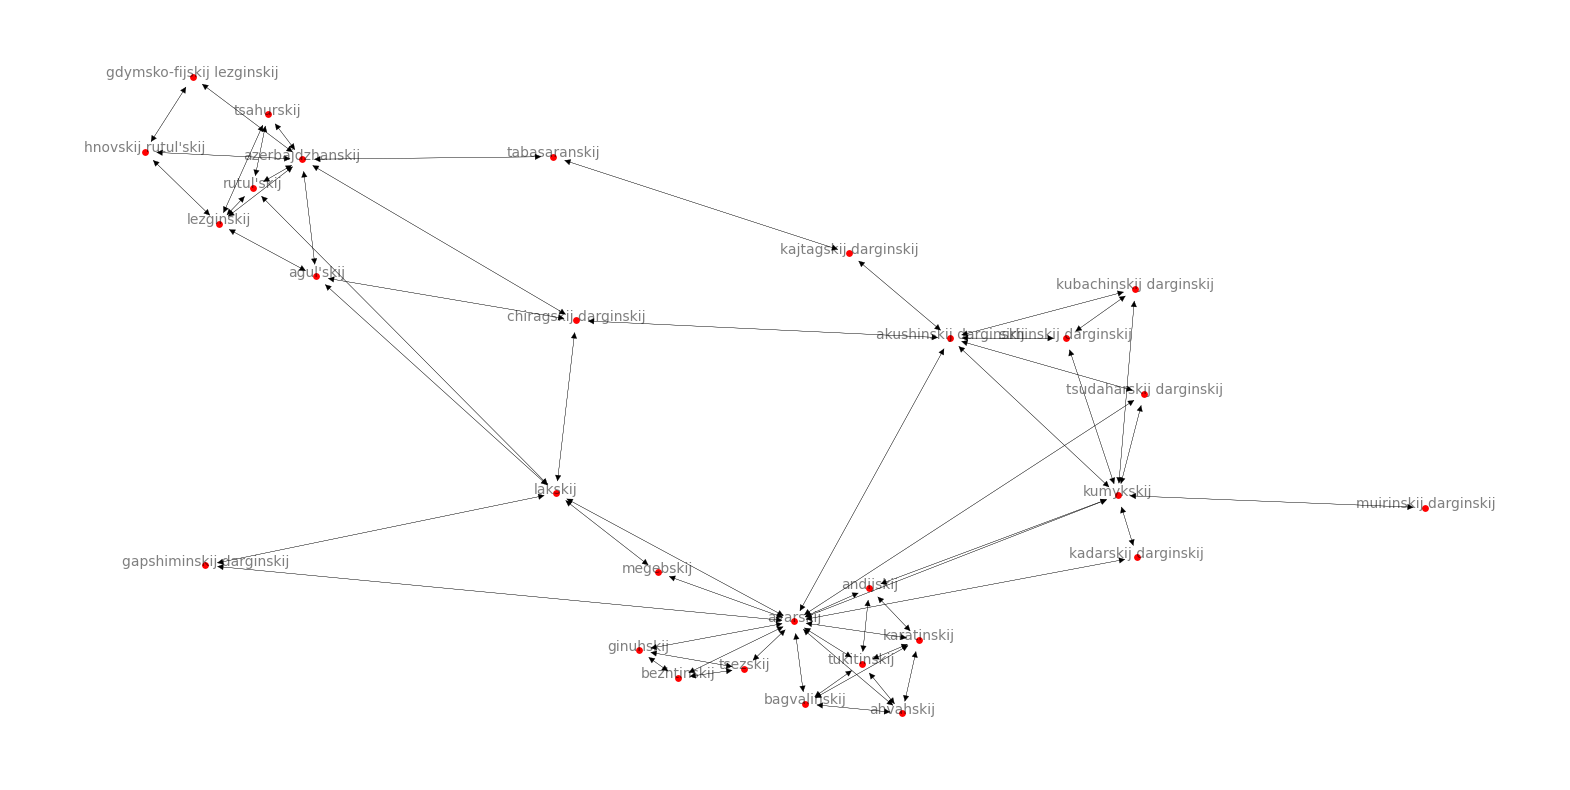

In [371]:
# raise labels above edges
pos_higher = {}
y_off = 0.01  # offset on the y axis
for k, v in pos.items():
    pos_higher[k] = (v[0], v[1] + y_off)

plt.figure(figsize=(20,10))
nx.draw_networkx_edges(G, pos, alpha=1, width=0.2)
nx.draw_networkx_nodes(G, pos, node_size=15, node_color='red')
nx.draw_networkx_labels(G, pos_higher, font_size=10, font_family='sans-serif', alpha=0.5)
_ = plt.axis('off')
